In [1]:
#ALTERED FROM:https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5
#READ METADATA FILE FOR TRAINING DATA
import pandas as pd
from pathlib import Path

user = 'krsd48' #change for each user

# Read metadata file
metadata_file = r'/home2/{}/crash-bang-wallop/data/data/metadata_2/METADATA_2.csv'.format(user)
metadata_file_noise = r'/home2/{}/crash-bang-wallop/data/data/metadata_2/METADATA_2_NOISE.csv'.format(user) 
mf = pd.read_csv(metadata_file)
nf = pd.read_csv(metadata_file_noise)

# Construct file path by concatenating fold and file name
mf['relative_path'] = '/' + mf['AUDIO'].astype(str)
nf['relative_path'] = '/' + nf['AUDIO'].astype(str)

# Take relevant columns
mf = mf[['relative_path', 'Y2']]
nf = nf[['relative_path', 'Y2']]

# Concatenate two dataframes
df = pd.concat([mf, nf], ignore_index=True)
df.head(2296) #show that df contains both noise and clean data

,relative_path,Y2
0,/fold_2/Bright_Black_10.wav,9
1,/fold_2/Bright_Black_100.wav,7
2,/fold_2/Bright_Black_101.wav,7
3,/fold_2/Bright_Black_102.wav,7
4,/fold_2/Bright_Black_103.wav,7
...,...,...
2291,/fold_2/Tool_99.wav,4
2292,/fold_2_noise/Bright_Black_10_noise.wav,9
2293,/fold_2_noise/Bright_Black_100_noise.wav,7
2294,/fold_2_noise/Bright_Black_101_noise.wav,7


In [2]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
import numpy as np

class AudioUtil():
  # ----------------------------
  # Load an audio file. Return the signal as a tensor and the sample rate
  # ----------------------------
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)
#convert mono to stereo
   # ----------------------------
  # Convert the given audio to the desired number of channels
  # ----------------------------
  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig])

    return ((resig, sr))
 # ----------------------------
  # Since Resample applies to a single channel, we resample one channel at a time
  # ----------------------------
  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))
 # ----------------------------
  # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
  # ----------------------------
  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)
  
  @staticmethod
  def noise(aud):
    signal, sr = aud
    noise_scalar = random.randint(0,4)*0.1               #random noise level           
    RMS = torch.sqrt(torch.mean(torch.square(signal)))    #scientific way of adding noise - see Bobby's Zotero for reference
    noise = torch.tensor(np.random.normal(0, RMS, signal.shape))
    signal_noise = torch.add(signal,noise,alpha = noise_scalar)
    signal_noise = signal_noise.float()
    return (signal_noise,sr)

 # ----------------------------
  # Shifts the signal to the left or right by some percent. Values at the end
  # are 'wrapped around' to the start of the transformed signal.
  # ----------------------------
  @staticmethod
  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)
  # ----------------------------
  # Generate a Spectrogram
  # ----------------------------
  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
    #spec = transforms.Spectrogram(n_fft=n_fft, hop_length=hop_len)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)
  # ----------------------------
  # Augment the Spectrogram by masking out some sections of it in both the frequency
  # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
  # overfitting and to help the model generalise better. The masked sections are
  # replaced with the mean value.
  # ----------------------------
  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

In [3]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
  def __init__(self, df, data_path):
    self.df = df
    self.data_path = str(data_path)
    self.duration = 4000
    self.sr = 44100
    self.channel = 2
    self.shift_pct = 0.4
            
  # ----------------------------
  # Number of items in dataset
  # ----------------------------
  def __len__(self):
    return len(self.df)    
    
  # ----------------------------
  # Get i'th item in dataset
  # ----------------------------
  def __getitem__(self, idx):
    # Absolute file path of the audio file - concatenate the audio directory with
    # the relative path
    audio_file = self.data_path + self.df.loc[idx, 'relative_path']
    # Get the Class ID
    class_id = self.df.loc[idx, 'Y2']

    aud = AudioUtil.open(audio_file)
    # Some sounds have a higher sample rate, or fewer channels compared to the
    # majority. So make all sounds have the same number of channels and same 
    # sample rate. Unless the sample rate is the same, the pad_trunc will still
    # result in arrays of different lengths, even though the sound duration is
    # the same.
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, self.channel)
    noise_sig=AudioUtil.noise(rechan)

    dur_aud = AudioUtil.pad_trunc(noise_sig, self.duration)
    shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    #aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return sgram, class_id

In [4]:
from torch.utils.data import random_split
from pathlib import Path
import os
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import init

data_path=r'/home2/{}/crash-bang-wallop/data/data'.format(user) #change user (krsd48) as needed
myds = SoundDS(df, data_path)

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])
# Create training and validation data loaders
train_dl =torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)
print(num_train)
print(num_val)

3667
917


In [5]:
# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Load the model and put it on the GPU if available
myModel = AudioClassifier()
model_name = '2022-08-15_09-08-19_model.pt' #specify model name
m_path = f'/home2/krsd48/crash-bang-wallop/NCC_Code/Models/{model_name}'
myModel.load_state_dict(torch.load(m_path, map_location=torch.device('cpu')))
myModel.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cpu')

In [11]:
# import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,names,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          save = False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.rcParams.update({'font.size': 22})
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.rcParams['figure.figsize'] = [15, 10]
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=24)
    plt.xlabel('Predicted label', fontsize=24)
    if save:
        plt.savefig('grades_confusion_matrix_dummy.png', bbox_inches='tight')
    plt.show()

In [7]:
largest_class_label = 0

def zeroR(input_data):
    if largest_class_label == 0:
        guesses = np.zeros(len(input_data))
    return guesses

In [8]:
def inference2 (model, val_dl):
    correct_prediction = 0
    total_prediction = 0
    wrong=[]

    da_labels = []
    true_vals = []
    guesses = []

  # Disable gradient updates
    with torch.no_grad():
        for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
            outputs = model(inputs)

      # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            cpu_prediction = prediction.cpu().numpy()
            cpu_labels = labels.cpu().numpy()
            for i in range(len(cpu_prediction)):
                true_vals.append(cpu_labels[i]) 
                guesses.append(cpu_prediction[i])
                da_labels.append(cpu_labels[i])
                if cpu_prediction[i]!=cpu_labels[i]:
                    wrong.append([cpu_prediction[i],cpu_labels[i]])
                    
      # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
    #print(wrong)
    acc = correct_prediction/total_prediction
    print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

    # make contain no duplicates
    da_labels = list(dict.fromkeys(da_labels))
    return acc, wrong, da_labels, true_vals, guesses

inf2 = inference2(myModel, val_dl)

Accuracy: 1.00, Total items: 917


Confusion matrix, without normalization
[[152   0   1   0   0   0   0   0   0   0]
 [  0  81   0   0   0   0   0   0   0   0]
 [  0   0 128   0   0   0   0   0   0   0]
 [  0   0   0 110   0   0   0   0   0   0]
 [  0   0   0   0  83   0   0   0   0   0]
 [  0   0   0   0   0  31   0   0   0   0]
 [  0   0   0   0   0   0  29   0   0   0]
 [  0   0   0   0   0   0   0  93   0   0]
 [  0   0   0   0   0   0   0   0 136   0]
 [  0   0   0   0   0   0   0   0   1  72]]


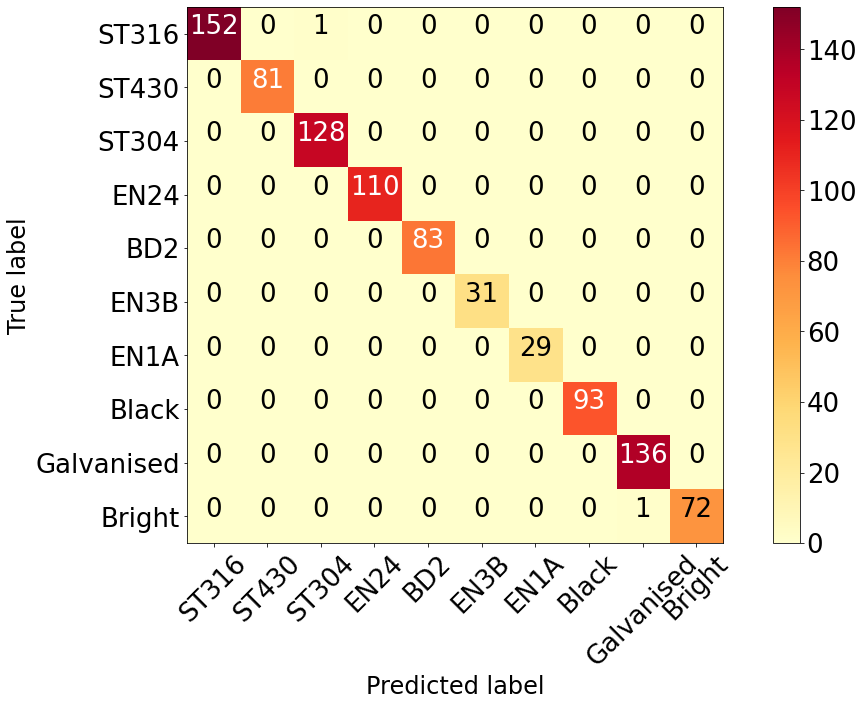

Confusion matrix, without normalization
[[153   0   0   0   0   0   0   0   0   0]
 [ 81   0   0   0   0   0   0   0   0   0]
 [128   0   0   0   0   0   0   0   0   0]
 [110   0   0   0   0   0   0   0   0   0]
 [ 83   0   0   0   0   0   0   0   0   0]
 [ 31   0   0   0   0   0   0   0   0   0]
 [ 29   0   0   0   0   0   0   0   0   0]
 [ 93   0   0   0   0   0   0   0   0   0]
 [136   0   0   0   0   0   0   0   0   0]
 [ 73   0   0   0   0   0   0   0   0   0]]


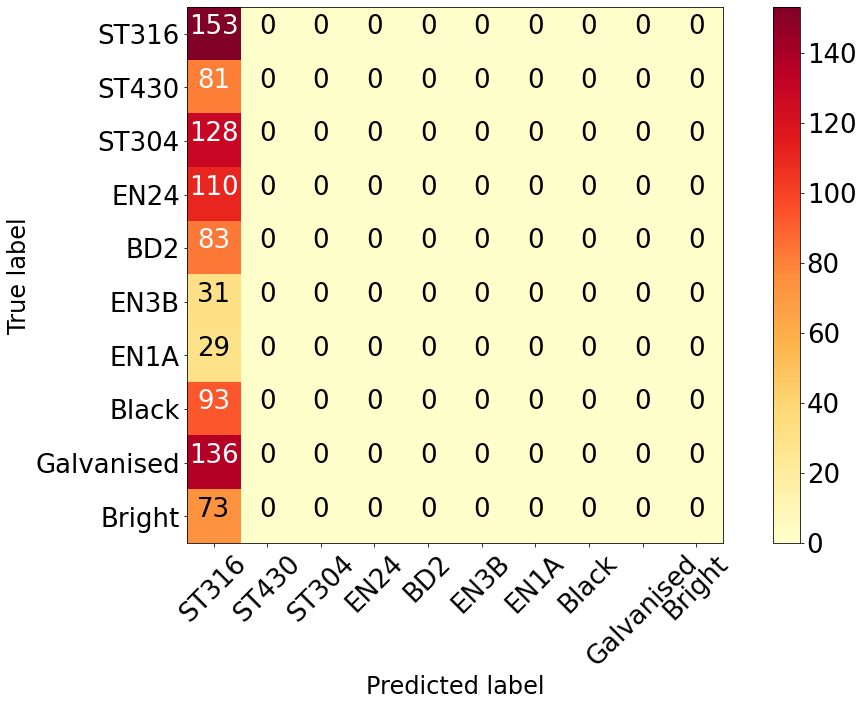

In [14]:
# Compute confusion matrix

#increase font size
plt.rcParams.update({'font.size': 26})

my_labels = sorted(inf2[2])
guesses = zeroR(inf2[4])
cnf_matrix = confusion_matrix(inf2[3],inf2[4], labels=my_labels)
cnf_matrix_dummy = confusion_matrix(inf2[3],guesses, labels=my_labels)
np.set_printoptions(precision=2)
#type_list = ["Stainless", "Carbon", "Tool", "Galvanised", "Engineering"] #ORDER MATTERS!
grade_list = ["ST316", "ST430", "ST304", "EN24", "BD2", "EN3B", "EN1A", "Black", "Galvanised", "Bright"] #ORDER MATTERS!
plot_confusion_matrix(cnf_matrix, classes=my_labels, names = grade_list ,normalize=False, title='Normalized confusion matrix', cmap = plt.cm.YlOrRd, save = False)
plot_confusion_matrix(cnf_matrix_dummy, classes=my_labels, names = grade_list ,normalize=False, title='Normalized confusion matrix', cmap = plt.cm.YlOrRd, save = True)